In [1]:
import numpy as np
import torch
import torchvision
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import torchvision.models as models

In [2]:
batch_size_train = 100
batch_size_test = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR10('cifar10', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR10('cifar10', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

100%|██████████| 170498071/170498071 [00:02<00:00, 62944912.71it/s]


Extracting cifar10/cifar-10-python.tar.gz to cifar10
Files already downloaded and verified


In [6]:
class Resnet34(nn.Module):
    def __init__(self):
        super(Resnet34, self).__init__() # Load pre-trained ResNet50 model
        self.resnet = models.resnet34(pretrained=False) # Modify the last layer for our classification task
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 10)
    def forward(self, x):
        x = self.resnet(x)
        return x

In [9]:
model = Resnet34().cuda()
print(model)

Resnet34(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [10]:
test_loss_min = np.Inf
LR=5e-4
optimizer = optim.Adam(model.parameters(), lr=LR)
test_acc_max = -100
history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}
for epoch in range(1, 10):
    print(f'Epoch {epoch} ...')
    # keep track of training and test loss
    train_loss = 0.0
    test_loss = 0.0
    train_correct = 0
    test_correct = 0
    train_total = 0
    test_total = 0
    #Changing the optimizer setting while training
    if epoch % 5 ==0:
      LR=LR*0.94
      optimizer = optim.Adam(model.parameters(), lr=LR)

    model.train()
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)

        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*data.size(0)
        # update training accuracy
        _, predicted = torch.max(output.data, 1)
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()

    #validate
    model.eval()
    for data, target in tqdm(test_loader):
        # move tensors to GPU
        data, target = data.cuda(), target.cuda()
        # forward pass
        output = model(data)

        loss = F.cross_entropy(output, target)
        # update average validation loss
        test_loss += loss.item()*data.size(0)
        # update validation accuracy
        _, predicted = torch.max(output.data, 1)
        test_total += target.size(0)
        test_correct += (predicted == target).sum().item()

    # calculate average losses and accuracy
    train_loss = train_loss/len(train_loader.dataset)
    test_loss = test_loss/len(test_loader.dataset)
    train_acc = 100 * train_correct / train_total
    test_acc = 100 * test_correct / test_total

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} - Testing Loss: {:.6f} - Training Accuracy: {:.2f}% - Testing Accuracy: {:.2f}%'.format(
        epoch+1, train_loss, test_loss, train_acc, test_acc))

    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Testing loss decreased ({:.6f} --> {:.6f}). The new model saved.'.format(test_loss_min, test_loss))
        torch.save(model.state_dict(), 'CIFAR10_Normal_ResNet_leastLoss.pt')
        test_loss_min = test_loss
    if test_acc >= test_acc_max:
        print('Testing Acc increased ({:.6f} --> {:.6f}). The new model saved.'.format(test_acc_max, test_acc))
        torch.save(model.state_dict(), 'CIFAR10_Normal_ResNet_Most_Accuracy.pt')
        test_acc_max = test_acc
    history['train_loss'].append(train_loss)
    history['valid_loss'].append(test_loss)
    history['train_acc'].append(train_acc)
    history['valid_acc'].append(test_acc)

Epoch 1 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 1.481403 - Testing Loss: 1.419150 - Training Accuracy: 46.47% - Testing Accuracy: 48.75%
Testing loss decreased (inf --> 1.419150). The new model saved.
Testing Acc increased (-100.000000 --> 48.750000). The new model saved.
Epoch 2 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 1.068523 - Testing Loss: 1.139980 - Training Accuracy: 62.25% - Testing Accuracy: 60.09%
Testing loss decreased (1.419150 --> 1.139980). The new model saved.
Testing Acc increased (48.750000 --> 60.090000). The new model saved.
Epoch 3 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.886222 - Testing Loss: 1.291516 - Training Accuracy: 69.13% - Testing Accuracy: 58.95%
Epoch 4 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.749857 - Testing Loss: 1.000170 - Training Accuracy: 73.71% - Testing Accuracy: 65.95%
Testing loss decreased (1.139980 --> 1.000170). The new model saved.
Testing Acc increased (60.090000 --> 65.950000). The new model saved.
Epoch 5 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.663912 - Testing Loss: 0.899420 - Training Accuracy: 76.84% - Testing Accuracy: 69.91%
Testing loss decreased (1.000170 --> 0.899420). The new model saved.
Testing Acc increased (65.950000 --> 69.910000). The new model saved.
Epoch 6 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.550585 - Testing Loss: 0.886642 - Training Accuracy: 80.87% - Testing Accuracy: 70.66%
Testing loss decreased (0.899420 --> 0.886642). The new model saved.
Testing Acc increased (69.910000 --> 70.660000). The new model saved.
Epoch 7 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.451658 - Testing Loss: 1.090934 - Training Accuracy: 84.14% - Testing Accuracy: 65.91%
Epoch 8 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.369664 - Testing Loss: 0.896297 - Training Accuracy: 87.18% - Testing Accuracy: 72.45%
Testing Acc increased (70.660000 --> 72.450000). The new model saved.
Epoch 9 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.306265 - Testing Loss: 0.997668 - Training Accuracy: 89.16% - Testing Accuracy: 71.44%


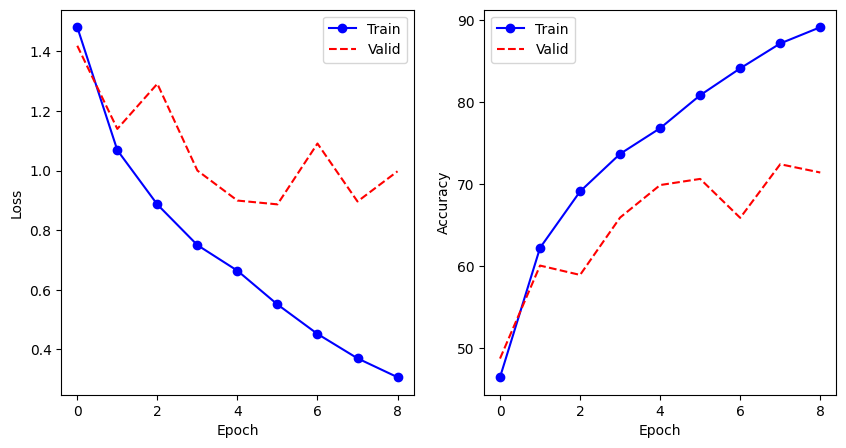

In [11]:
import matplotlib.pyplot as plt
fig=plt.figure(1,figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], 'bo-', label='Train')
plt.plot(history['valid_loss'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], 'bo-', label='Train')
plt.plot(history['valid_acc'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [12]:
modelSynScaL = Resnet34().cuda()
test_loss_min_SynScaL = np.Inf
LR=5e-4
optimizer = optim.Adam(modelSynScaL.parameters(), lr=LR)
test_acc_max_SynScaL = -100
historySynScaL = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}
for epoch in range(1, 10):
    print(f'Epoch {epoch} ...')
    # keep track of training and test loss
    train_loss = 0.0
    test_loss = 0.0
    train_correct = 0
    test_correct = 0
    train_total = 0
    test_total = 0
    #Changing the optimizer setting while training
    if epoch % 5 ==0:
      LR=LR*0.94
      optimizer = optim.Adam(modelSynScaL.parameters(), lr=LR)

    modelSynScaL.train()
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = modelSynScaL(data)

        loss = F.cross_entropy(output, target)+ 1.0 * (0.1 - output.mean())**2
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*data.size(0)
        # update training accuracy
        _, predicted = torch.max(output.data, 1)
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()

    #validate
    modelSynScaL.eval()
    for data, target in tqdm(test_loader):
        # move tensors to GPU
        data, target = data.cuda(), target.cuda()
        # forward pass
        output = modelSynScaL(data)

        loss = F.cross_entropy(output, target) +  1.0 * (0.1 - output.mean())**2
        # update average validation loss
        test_loss += loss.item()*data.size(0)
        # update validation accuracy
        _, predicted = torch.max(output.data, 1)
        test_total += target.size(0)
        test_correct += (predicted == target).sum().item()

    # calculate average losses and accuracy
    train_loss = train_loss/len(train_loader.dataset)
    test_loss = test_loss/len(test_loader.dataset)
    train_acc = 100 * train_correct / train_total
    test_acc = 100 * test_correct / test_total

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} - Testing Loss: {:.6f} - Training Accuracy: {:.2f}% - Testing Accuracy: {:.2f}%'.format(
        epoch+1, train_loss, test_loss, train_acc, test_acc))

    # save model if validation loss has decreased
    if test_loss <= test_loss_min_SynScaL:
        print('Testing loss decreased ({:.6f} --> {:.6f}). The new model saved.'.format(test_loss_min_SynScaL, test_loss))
        torch.save(modelSynScaL.state_dict(), 'CIFAR10_SynScaL_ResNet_leastLoss.pt')
        test_loss_min_SynScaL = test_loss
    if test_acc >= test_acc_max_SynScaL:
        print('Testing Acc increased ({:.6f} --> {:.6f}). The new model saved.'.format(test_acc_max_SynScaL, test_acc))
        torch.save(modelSynScaL.state_dict(), 'CIFAR10_SynScaL_ResNet_Most_Accuracy.pt')
        test_acc_max_SynScaL = test_acc
    historySynScaL['train_loss'].append(train_loss)
    historySynScaL['valid_loss'].append(test_loss)
    historySynScaL['train_acc'].append(train_acc)
    historySynScaL['valid_acc'].append(test_acc)

Epoch 1 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 1.468311 - Testing Loss: 1.392607 - Training Accuracy: 47.07% - Testing Accuracy: 51.71%
Testing loss decreased (inf --> 1.392607). The new model saved.
Testing Acc increased (-100.000000 --> 51.710000). The new model saved.
Epoch 2 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 1.061985 - Testing Loss: 1.099592 - Training Accuracy: 62.43% - Testing Accuracy: 61.93%
Testing loss decreased (1.392607 --> 1.099592). The new model saved.
Testing Acc increased (51.710000 --> 61.930000). The new model saved.
Epoch 3 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.874312 - Testing Loss: 0.953688 - Training Accuracy: 69.33% - Testing Accuracy: 67.62%
Testing loss decreased (1.099592 --> 0.953688). The new model saved.
Testing Acc increased (61.930000 --> 67.620000). The new model saved.
Epoch 4 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.744002 - Testing Loss: 0.926562 - Training Accuracy: 73.77% - Testing Accuracy: 68.19%
Testing loss decreased (0.953688 --> 0.926562). The new model saved.
Testing Acc increased (67.620000 --> 68.190000). The new model saved.
Epoch 5 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.658960 - Testing Loss: 0.920314 - Training Accuracy: 77.17% - Testing Accuracy: 69.23%
Testing loss decreased (0.926562 --> 0.920314). The new model saved.
Testing Acc increased (68.190000 --> 69.230000). The new model saved.
Epoch 6 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.531381 - Testing Loss: 1.069757 - Training Accuracy: 81.79% - Testing Accuracy: 67.60%
Epoch 7 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.445986 - Testing Loss: 0.944850 - Training Accuracy: 84.47% - Testing Accuracy: 71.31%
Testing Acc increased (69.230000 --> 71.310000). The new model saved.
Epoch 8 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.355898 - Testing Loss: 1.043187 - Training Accuracy: 87.65% - Testing Accuracy: 69.34%
Epoch 9 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.296293 - Testing Loss: 0.906465 - Training Accuracy: 89.72% - Testing Accuracy: 73.37%
Testing loss decreased (0.920314 --> 0.906465). The new model saved.
Testing Acc increased (71.310000 --> 73.370000). The new model saved.


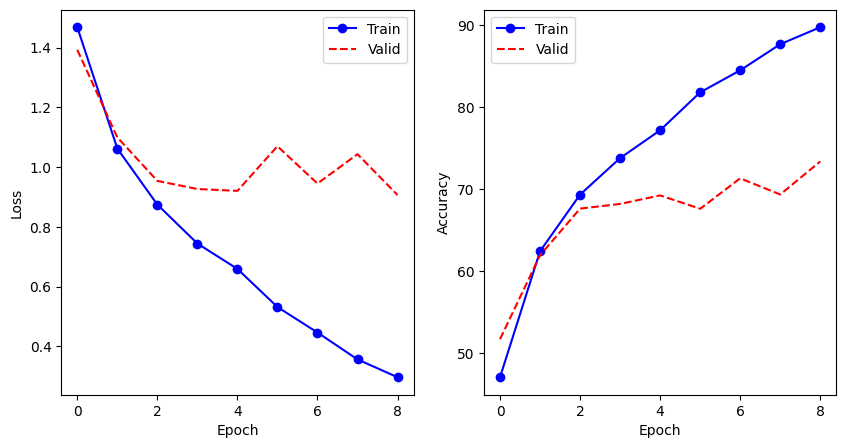

In [13]:
fig=plt.figure(1,figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(historySynScaL['train_loss'], 'bo-', label='Train')
plt.plot(historySynScaL['valid_loss'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(historySynScaL['train_acc'], 'bo-', label='Train')
plt.plot(historySynScaL['valid_acc'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [14]:
def update_param(parameter_data, activation, gamma=0.1,mean = 0.1):
    activation = activation.data.numpy().mean(axis=(0)).squeeze()[:,None]
    param = parameter_data.numpy()
    new_param = param+gamma*np.clip((param*param)*(mean - activation).mean(),-1,1)
    return torch.from_numpy(new_param)
def perform_update(m):
    if type(m) == nn.Linear:
        m.eval()
        im = np.random.uniform(-1, 1, (100, m.in_features))+0.1
        im_as_ten = torch.from_numpy(im).float().cuda()
        x = Variable(im_as_ten, requires_grad=True)
        x = F.relu(m(x))
        m.weight.data = update_param(m.weight.data.cpu(),activation=x.cpu()).cuda()
    if type(m) == nn.Conv2d:
        m.eval()
        im = np.random.uniform(-1, 1, (100, m.weight.size()[1],28,28))+0.1
        im_as_ten = torch.from_numpy(im).float().cuda()
        x = Variable(im_as_ten, requires_grad=True)
        x = F.relu(m(x))
        m.weight.data = update_param(m.weight.data.cpu(),activation=x.cpu()).cuda()

In [15]:
modelSynScaW = Resnet34().cuda()
test_loss_min_SynScaW= np.Inf
test_acc_max_SynScaW = -100
LR=5e-4
optimizer = optim.Adam(modelSynScaW.parameters(), lr=LR)
historySynScaW = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}
for epoch in range(1, 10):
    print(f'Epoch {epoch} ...')
    # keep track of training and test loss
    train_loss = 0.0
    test_loss = 0.0
    train_correct = 0
    test_correct = 0
    train_total = 0
    test_total = 0
    #Changing the optimizer setting while training
    if epoch % 5 ==0:
      LR=LR*0.94
      optimizer = optim.Adam(modelSynScaW.parameters(), lr=LR)

    modelSynScaW.train()
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = modelSynScaW(data)

        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*data.size(0)
        # update training accuracy
        _, predicted = torch.max(output.data, 1)
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()
    modelSynScaW.apply(perform_update)
    #validate
    modelSynScaW.eval()
    for data, target in tqdm(test_loader):
        # move tensors to GPU
        data, target = data.cuda(), target.cuda()
        # forward pass
        output = modelSynScaW(data)

        loss = F.cross_entropy(output, target)
        # update average validation loss
        test_loss += loss.item()*data.size(0)
        # update validation accuracy
        _, predicted = torch.max(output.data, 1)
        test_total += target.size(0)
        test_correct += (predicted == target).sum().item()

    # calculate average losses and accuracy
    train_loss = train_loss/len(train_loader.dataset)
    test_loss = test_loss/len(test_loader.dataset)
    train_acc = 100 * train_correct / train_total
    test_acc = 100 * test_correct / test_total

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} - Testing Loss: {:.6f} - Training Accuracy: {:.2f}% - Testing Accuracy: {:.2f}%'.format(
        epoch+1, train_loss, test_loss, train_acc, test_acc))

    # save model if validation loss has decreased
    if test_loss <= test_loss_min_SynScaW:
        print('Testing loss decreased ({:.6f} --> {:.6f}). The new model saved.'.format(test_loss_min_SynScaW, test_loss))
        torch.save(modelSynScaW.state_dict(), 'CIFAR10_SynScaW_ResNet_leastLoss.pt')
        test_loss_min_SynScaW = test_loss
    if test_acc >= test_acc_max_SynScaW:
        print('Testing Acc increased ({:.6f} --> {:.6f}). The new model saved.'.format(test_acc_max_SynScaW, test_acc))
        torch.save(modelSynScaW.state_dict(), 'CIFAR10_SynScaW_ResNet_Most_Accuracy.pt')
        test_acc_max_SynScaW = test_acc
    historySynScaW['train_loss'].append(train_loss)
    historySynScaW['valid_loss'].append(test_loss)
    historySynScaW['train_acc'].append(train_acc)
    historySynScaW['valid_acc'].append(test_acc)

Epoch 1 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 1.483643 - Testing Loss: 1.233206 - Training Accuracy: 46.31% - Testing Accuracy: 54.86%
Testing loss decreased (inf --> 1.233206). The new model saved.
Testing Acc increased (-100.000000 --> 54.860000). The new model saved.
Epoch 2 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 1.063961 - Testing Loss: 1.204735 - Training Accuracy: 62.23% - Testing Accuracy: 58.81%
Testing loss decreased (1.233206 --> 1.204735). The new model saved.
Testing Acc increased (54.860000 --> 58.810000). The new model saved.
Epoch 3 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.866392 - Testing Loss: 1.092653 - Training Accuracy: 69.62% - Testing Accuracy: 62.75%
Testing loss decreased (1.204735 --> 1.092653). The new model saved.
Testing Acc increased (58.810000 --> 62.750000). The new model saved.
Epoch 4 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.739141 - Testing Loss: 0.970870 - Training Accuracy: 74.19% - Testing Accuracy: 67.91%
Testing loss decreased (1.092653 --> 0.970870). The new model saved.
Testing Acc increased (62.750000 --> 67.910000). The new model saved.
Epoch 5 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.644162 - Testing Loss: 0.861792 - Training Accuracy: 77.60% - Testing Accuracy: 71.01%
Testing loss decreased (0.970870 --> 0.861792). The new model saved.
Testing Acc increased (67.910000 --> 71.010000). The new model saved.
Epoch 6 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.531260 - Testing Loss: 0.980666 - Training Accuracy: 81.39% - Testing Accuracy: 69.35%
Epoch 7 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.434261 - Testing Loss: 0.866607 - Training Accuracy: 84.92% - Testing Accuracy: 72.48%
Testing Acc increased (71.010000 --> 72.480000). The new model saved.
Epoch 8 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.357362 - Testing Loss: 0.886549 - Training Accuracy: 87.54% - Testing Accuracy: 72.48%
Testing Acc increased (72.480000 --> 72.480000). The new model saved.
Epoch 9 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.288399 - Testing Loss: 1.041771 - Training Accuracy: 89.87% - Testing Accuracy: 70.40%


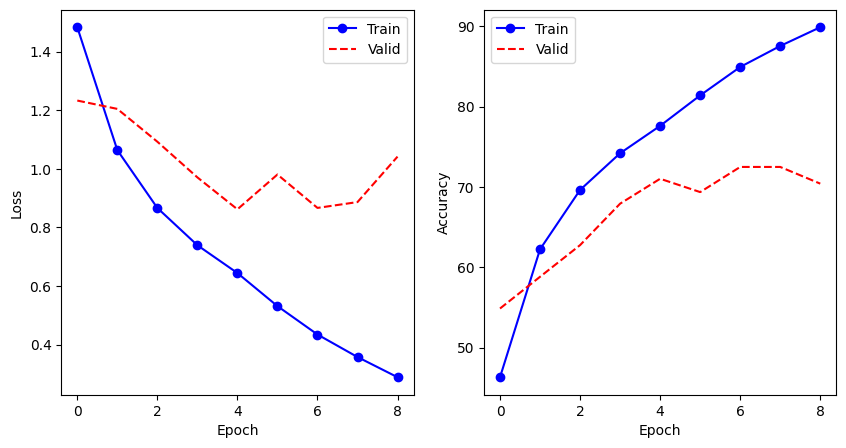

In [16]:

import matplotlib.pyplot as plt
fig=plt.figure(1,figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(historySynScaW['train_loss'], 'bo-', label='Train')
plt.plot(historySynScaW['valid_loss'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(historySynScaW['train_acc'], 'bo-', label='Train')
plt.plot(historySynScaW['valid_acc'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [17]:
from tabulate import tabulate
data = [['Loss', test_loss_min, test_loss_min_SynScaL, test_loss_min_SynScaW],
['Accuracy', test_acc_max, test_acc_max_SynScaL, test_acc_max_SynScaW],
]
print (tabulate(data, headers=["Type", "Normal", "SynScaL", "SynScaW"]))

Type         Normal    SynScaL    SynScaW
--------  ---------  ---------  ---------
Loss       0.886642   0.906465   0.861792
Accuracy  72.45      73.37      72.48
